In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
# import Ngl
# import Nio 
# import metpy.calc as mpc
# from metpy.units import units


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
## Function from Brian Medeiros to convert times to middle of period 
#  rather than the end of the averaging period. 

def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [4]:
'''
Define function to read in 2-day sims and assemble hindcast-style timeseries by ignoring the first day as spin up. 
Inputs:  
   dataDir:      directory where files are saved 
   hmgFile0:     First file of HMG case (usually a slightly different name)
   htgFile0:     First file of HTG case (usually a slightly different name)
   hmgFileStart: Case name (beginning of the file names), specifying HMG case
   htgFileStart: Case name specifying HTG case
   middleFile:   Filename following day specification (assumed to be the same between HMG and HTG cases)
   endFile:      End of filename (assumed to be the same between HMG and HTG cases)
   dayArr:       Array of days in filenames 
   monthArr:     Array of months in filenames 
'''

def readData_2daySims(dataDir,
                      hmgFile0,
                      htgFile0,
                      hmgFile0_CLM,
                      htgFile0_CLM,
                      hmgFileStart,
                      htgFileStart,
                      middleFile,
                      middleFileCLM,
                      endFile,
                      dayArr, 
                      monthArr): 
    
    for iDay in range(len(dayArr)-2): 
        if iDay==0:
            hmgFile = dataDir+hmgFile0
            htgFile = dataDir+htgFile0
            
            hmgFileCLM = dataDir+hmgFile0_CLM
            htgFileCLM = dataDir+htgFile0_CLM
        
        else:
            # Define full file names 
            hmgFile    = dataDir+hmgFileStart+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
            htgFile    = dataDir+htgFileStart+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
            hmgFileCLM   = dataDir+hmgFileStart+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFileCLM+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
            htgFileCLM   = dataDir+htgFileStart+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFileCLM+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile


            
        # ---------------------- 
        # Read in data
        # ----------------------
        # Read in files with homogeneous surface forcing prescribed 
        with xr.open_dataset(hmgFile, decode_times=True) as hmg_DS:
            hmg_DS['time']  = hmg_DS.indexes['time'].to_datetimeindex()

            # Select day: 
            times_hmg  = pd.DatetimeIndex(hmg_DS['time'].values)
            iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
            iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
            iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])

            if iDay==0:
                hmgDS = hmg_DS.isel(time=iTimeRange)
            else:
                hmgDS = xr.concat([hmgDS, hmg_DS.isel(time=iTimeRange)], dim='time')
                
        with xr.open_dataset(hmgFileCLM, decode_times=True) as hmg_DS_CLM:
            hmg_DS_CLM['time']  = hmg_DS_CLM.indexes['time'].to_datetimeindex()
            hmg_DS_CLM['time']  = hmg_DS['time'].values
            
            # Select day: 
            times_hmg  = pd.DatetimeIndex(hmg_DS_CLM['time'].values)
            iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
            iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
            iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
            
            if iDay==0:
                hmgDS_clm = hmg_DS_CLM.isel(time=iTimeRange)
            else:
                hmgDS_clm = xr.concat([hmgDS_clm, hmg_DS_CLM.isel(time=iTimeRange)], dim='time')


        # Read in files with heterogeneous surface forcing prescribed     
        with xr.open_dataset(htgFile, decode_times=True) as htg_DS:
            htg_DS['time']  = htg_DS.indexes['time'].to_datetimeindex()

            # Select day: 
            times_htg  = pd.DatetimeIndex(htg_DS['time'].values)
            iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
            iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
            iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])

            if iDay==0:
                htgDS = htg_DS.isel(time=iTimeRange)
            else:
                htgDS = xr.concat([htgDS, htg_DS.isel(time=iTimeRange)], dim='time')

        with xr.open_dataset(htgFileCLM, decode_times=True) as htg_DS_CLM:
            htg_DS_CLM['time']  = htg_DS_CLM.indexes['time'].to_datetimeindex()
            htg_DS_CLM['time']  = htg_DS['time'].values
            
            # Select day: 
            times_htg  = pd.DatetimeIndex(htg_DS_CLM['time'].values)
            iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
            iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
            iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])

            if iDay==0:
                htgDS_clm = htg_DS_CLM.isel(time=iTimeRange)
            else:
                htgDS_clm = xr.concat([htgDS_clm, htg_DS_CLM.isel(time=iTimeRange)], dim='time')
                

        print('Done with day %i' % iDay)
    
    
    return hmgDS,htgDS,hmgDS_clm,htgDS_clm  

## Read in data

In [7]:
## Default land surface option 
# -------------------------------------------------------------------------

# Where the files are saved (locally):
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/FinalOption_defaultSfc_betterFinidat_moreMomentsPlusReorder/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start'  
htg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start'

middleFile      = '.cam.h0.2015-'   # Default 20 min coupling
middleFileCLM   = '.clm2.h0.2015-'
endFile         = '-84585.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months        = np.ones(93)
months[0]     = 5
months[1:31]  = 6
months[31:62] = 7
months[62::]  = 8

days        = np.ones(93)
days[0]     = 31
days[1:31]  = np.arange(1,31)
days[31:62] = np.arange(1,32)
days[62::]  = np.arange(1,32)

# First file names 
hmgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
htgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
hmgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'
htgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'


In [10]:
hmgDS_origSfc,htgDS_origSfc, hmgDSclm_origSfc,htgDSclm_origSfc = readData_2daySims(dataDir,
                                                 hmgFile0,
                                                 htgFile0,
                                                 hmgFile0_CLM, 
                                                 htgFile0_CLM,
                                                 hmg_startFile,
                                                 htg_startFile,
                                                 middleFile,
                                                 middleFileCLM,
                                                 endFile,
                                                 days, 
                                                 months)

Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28
Done with day 29
Done with day 30
Done with day 31
Done with day 32
Done with day 33
Done with day 34
Done with day 35
Done with day 36
Done with day 37
Done with day 38
Done with day 39
Done with day 40
Done with day 41
Done with day 42
Done with day 43
Done with day 44
Done with day 45
Done with day 46
Done with day 47
Done with day 48
Done with day 49
Done with day 50
Done with day 51
Done with day 52
Done with day 53
Done with day 54
Done with day 55
Done with day 56
Done with day 57
Done with day 58
Done wi

In [33]:
## Idealized land surface option 
# -------------------------------------------------------------------------

# Where the files are saved (locally):
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/FinalOption_UrbanLakeGrassTree_betterFinidat_moreMomentsPlusReorder/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start'  
htg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start'

middleFile      = '.cam.h0.2015-'   # Default 20 min coupling
middleFileCLM   = '.clm2.h0.2015-'
endFile         = '-84585.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
# months        = np.ones(93)
# months[0]     = 5
# months[1:31]  = 6
# months[31:62] = 7
# months[62::]  = 8

# days        = np.ones(93)
# days[0]     = 31
# days[1:31]  = np.arange(1,31)
# days[31:62] = np.arange(1,32)
# days[62::]  = np.arange(1,32)

months        = np.ones(32)
months[0]     = 5
months[1:31]  = 6
# months[31:62] = 7
# months[62::]  = 8

days        = np.ones(32)
days[0]     = 31
days[1:31]  = np.arange(1,31)
# days[31:62] = np.arange(1,32)
# days[62::]  = np.arange(1,32)

# First file names 
hmgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
htgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
hmgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HMG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'
htgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HTG_betterFinidat4_MoreMomentsPlusReorder_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'

hmgDS_idlzSfc,htgDS_idlzSfc, hmgDSclm_idlzSfc,htgDSclm_idlzSfc = readData_2daySims(dataDir,
                                                 hmgFile0,
                                                 htgFile0,
                                                 hmgFile0_CLM, 
                                                 htgFile0_CLM,
                                                 hmg_startFile,
                                                 htg_startFile,
                                                 middleFile,
                                                 middleFileCLM,
                                                 endFile,
                                                 days, 
                                                 months)



Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28
Done with day 29


In [58]:
# ## Idealized land surface option 
# # -------------------------------------------------------------------------

# # Where the files are saved (locally):
# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/FinalOption_UrbanLakeGrassTree/'

# # File naming conventions: 
# hmg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HMG_2daySims.Start'  
# htg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HTG_2daySims.Start'

# middleFile      = '.cam.h0.2015-'   # Default 20 min coupling
# middleFileCLM   = '.clm2.h0.2015-'
# endFile         = '-84585.nc'

# # Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
# months        = np.ones(93)
# months[0]     = 5
# months[1:31]  = 6
# months[31:62] = 7
# months[62::]  = 8

# days        = np.ones(93)
# days[0]     = 31
# days[1:31]  = np.arange(1,31)
# days[31:62] = np.arange(1,32)
# days[62::]  = np.arange(1,32)

# # First file names 
# hmgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HMG_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
# htgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HTG_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
# hmgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HMG_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'
# htgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.UrbanLakeGrassTree.HTG_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'

# hmgDS_idlzSfc,htgDS_idlzSfc, hmgDSclm_idlzSfc,htgDSclm_idlzSfc = readData_2daySims(dataDir,
#                                                  hmgFile0,
#                                                  htgFile0,
#                                                  hmgFile0_CLM, 
#                                                  htgFile0_CLM,
#                                                  hmg_startFile,
#                                                  htg_startFile,
#                                                  middleFile,
#                                                  middleFileCLM,
#                                                  endFile,
#                                                  days, 
#                                                  months)


Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28
Done with day 29
Done with day 30
Done with day 31
Done with day 32
Done with day 33
Done with day 34
Done with day 35
Done with day 36
Done with day 37
Done with day 38
Done with day 39
Done with day 40
Done with day 41
Done with day 42
Done with day 43
Done with day 44
Done with day 45
Done with day 46
Done with day 47
Done with day 48
Done with day 49
Done with day 50
Done with day 51
Done with day 52
Done with day 53
Done with day 54
Done with day 55
Done with day 56
Done with day 57
Done with day 58
Done wi

In [72]:
## Default land surface option, HTG variances * 2 
# -------------------------------------------------------------------------

# Where the files are saved (locally):
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/FinalOption_HTGvariancesTimes2/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_2daySims.Start'  
htg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGmultiplier_2x.HTG_2daySims.Start'

middleFile      = '.cam.h0.2015-'   # Default 20 min coupling
middleFileCLM   = '.clm2.h0.2015-'
endFile         = '-84585.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months        = np.ones(93)
months[0]     = 5
months[1:31]  = 6
months[31:62] = 7
months[62::]  = 8

days        = np.ones(93)
days[0]     = 31
days[1:31]  = np.arange(1,31)
days[31:62] = np.arange(1,32)
days[62::]  = np.arange(1,32)

# First file names 
hmgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
htgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGmultiplier_2x.HTG_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
hmgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'
htgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGmultiplier_2x.HTG_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'

hmgDS_origSfc,htgDS_x2, hmgDSclm_origSfc,htgDSclm_x2 = readData_2daySims(dataDir,
                                                 hmgFile0,
                                                 htgFile0,
                                                 hmgFile0_CLM, 
                                                 htgFile0_CLM,
                                                 hmg_startFile,
                                                 htg_startFile,
                                                 middleFile,
                                                 middleFileCLM,
                                                 endFile,
                                                 days, 
                                                 months)


Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28
Done with day 29
Done with day 30
Done with day 31
Done with day 32
Done with day 33
Done with day 34
Done with day 35
Done with day 36
Done with day 37
Done with day 38
Done with day 39
Done with day 40
Done with day 41
Done with day 42
Done with day 43
Done with day 44
Done with day 45
Done with day 46
Done with day 47
Done with day 48
Done with day 49
Done with day 50
Done with day 51
Done with day 52
Done with day 53
Done with day 54
Done with day 55
Done with day 56
Done with day 57
Done with day 58
Done wi

In [74]:
## Default land surface option, HTG variances * 5 
# -------------------------------------------------------------------------

# Where the files are saved (locally):
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/HindcastTests/FinalOption_HTGvariancesTimes5/'

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_2daySims.Start'  
htg_startFile   = 'FSCAM.T42_T42.FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGmultiplier_5x.HTG_2daySims.Start'

middleFile      = '.cam.h0.2015-'   # Default 20 min coupling
middleFileCLM   = '.clm2.h0.2015-'
endFile         = '-84585.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months        = np.ones(93)
months[0]     = 5
months[1:31]  = 6
months[31:62] = 7
months[62::]  = 8

days        = np.ones(93)
days[0]     = 31
days[1:31]  = np.arange(1,31)
days[31:62] = np.arange(1,32)
days[62::]  = np.arange(1,32)

# First file names 
hmgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
htgFile0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGmultiplier_5x.HTG_2daySims.Start0531.cam.h0.2015-05-31-84585.nc'
hmgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'
htgFile0_CLM = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGmultiplier_5x.HTG_2daySims.Start0531.clm2.h0.2015-05-31-84585.nc'

hmgDS_origSfc,htgDS_x5, hmgDSclm_origSfc,htgDSclm_x5 = readData_2daySims(dataDir,
                                                 hmgFile0,
                                                 htgFile0,
                                                 hmgFile0_CLM, 
                                                 htgFile0_CLM,
                                                 hmg_startFile,
                                                 htg_startFile,
                                                 middleFile,
                                                 middleFileCLM,
                                                 endFile,
                                                 days, 
                                                 months)



Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28
Done with day 29
Done with day 30
Done with day 31
Done with day 32
Done with day 33
Done with day 34
Done with day 35
Done with day 36
Done with day 37
Done with day 38
Done with day 39
Done with day 40
Done with day 41
Done with day 42
Done with day 43
Done with day 44
Done with day 45
Done with day 46
Done with day 47
Done with day 48
Done with day 49
Done with day 50
Done with day 51
Done with day 52
Done with day 53
Done with day 54
Done with day 55
Done with day 56
Done with day 57
Done with day 58
Done wi

In [8]:
obsFile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'

with xr.open_dataset(obsFile, decode_times=True) as obsDS:
    obsT = obsDS.T_srf.values + 273.15    #Convert C to K


**Convert times**

In [11]:
## Convert to local times...
hmgDS_origSfc_local = hmgDS_origSfc.copy(deep=True)
htgDS_origSfc_local = htgDS_origSfc.copy(deep=True)
hmgDSclm_origSfc_local = hmgDSclm_origSfc.copy(deep=True)
htgDSclm_origSfc_local = htgDSclm_origSfc.copy(deep=True)

# Convert times to a pandas datetime array, with UTC timezone
localTimes = hmgDS_origSfc['time'].values - np.timedelta64(5,'h')


# Replace time dimension with local time
hmgDS_origSfc_local = hmgDS_origSfc_local.assign_coords({"time": localTimes})
htgDS_origSfc_local = htgDS_origSfc_local.assign_coords({"time": localTimes})

hmgDSclm_origSfc_local = hmgDSclm_origSfc_local.assign_coords({"time": localTimes})
htgDSclm_origSfc_local = htgDSclm_origSfc_local.assign_coords({"time": localTimes})


In [34]:
## Convert to local times...
hmgDS_idlzSfc_local = hmgDS_idlzSfc.copy(deep=True)
htgDS_idlzSfc_local = htgDS_idlzSfc.copy(deep=True)
hmgDSclm_idlzSfc_local = hmgDSclm_idlzSfc.copy(deep=True)
htgDSclm_idlzSfc_local = htgDSclm_idlzSfc.copy(deep=True)

# Convert times to a pandas datetime array, with UTC timezone
localTimes = hmgDS_idlzSfc['time'].values - np.timedelta64(5,'h')


# Replace time dimension with local time
hmgDS_idlzSfc_local = hmgDS_idlzSfc_local.assign_coords({"time": localTimes})
htgDS_idlzSfc_local = htgDS_idlzSfc_local.assign_coords({"time": localTimes})

hmgDSclm_idlzSfc_local = hmgDSclm_idlzSfc_local.assign_coords({"time": localTimes})
htgDSclm_idlzSfc_local = htgDSclm_idlzSfc_local.assign_coords({"time": localTimes})



In [75]:
## Convert to local times...
htgDS_x2_local    = htgDS_x2.copy(deep=True)
htgDSclm_x2_local = htgDSclm_x2.copy(deep=True)

htgDS_x5_local    = htgDS_x5.copy(deep=True)
htgDSclm_x5_local = htgDSclm_x5.copy(deep=True)

# Convert times to a pandas datetime array, with UTC timezone
localTimes = htgDS_x2['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
htgDS_x2_local    = htgDS_x2_local.assign_coords({"time": localTimes})
htgDSclm_x2_local = htgDSclm_x2_local.assign_coords({"time": localTimes})

htgDS_x5_local    = htgDS_x5_local.assign_coords({"time": localTimes})
htgDSclm_x5_local = htgDSclm_x5_local.assign_coords({"time": localTimes})


## Time-height plots

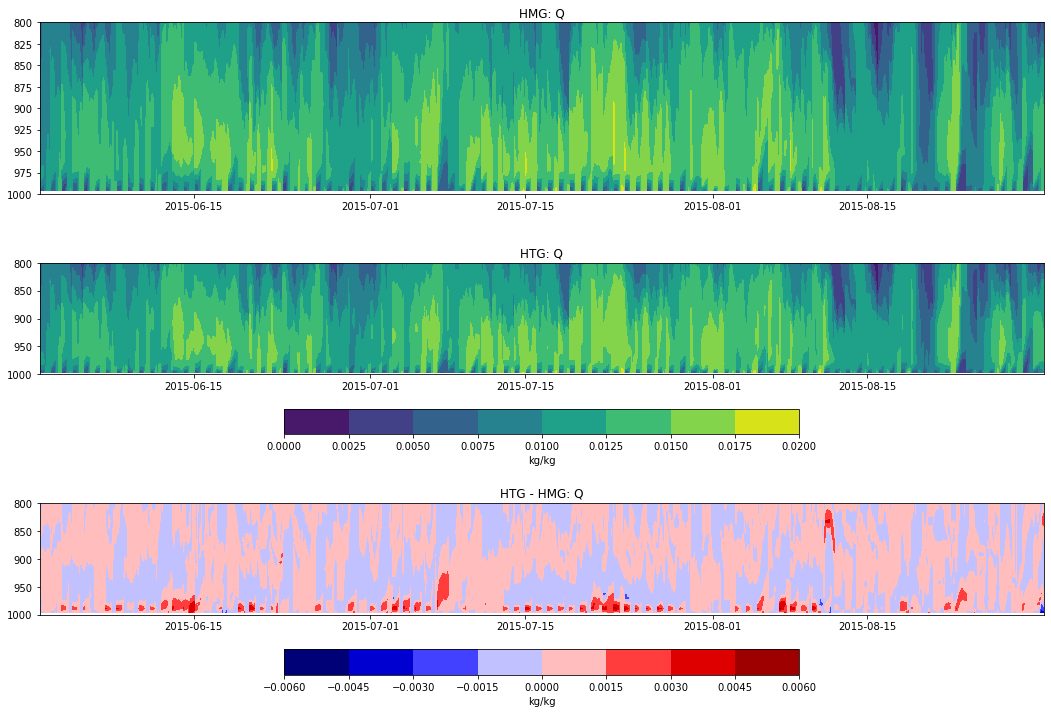

In [110]:
fig,axs = plt.subplots(3,1, figsize=(18,12))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

varName = 'Q'
levs    = hmgDS_origSfc_local.lev.values

axs[0].contourf(hmgDS_origSfc_local.time.values, levs, 
                np.transpose(np.squeeze(hmgDS_origSfc_local[varName].values)))
axs[0].set_title('HMG: '+varName)
axs[0].invert_yaxis()
axs[0].set_ylim([1000,800])


cmap=axs[1].contourf(htgDS_origSfc_local.time.values, levs, 
                np.transpose(np.squeeze(htgDS_origSfc_local[varName].values)))
axs[1].set_title('HTG: '+varName)
axs[1].invert_yaxis()
axs[1].set_ylim([1000,800])
fig.colorbar(cmap,ax=axs[1],orientation='horizontal',pad=0.2,shrink=0.6,label=hmgDS_origSfc[varName].units)

dmap = axs[2].contourf(htgDS_origSfc_local.time.values, levs, 
                np.transpose(np.squeeze(htgDS_origSfc_local[varName].values) - np.squeeze(hmgDS_origSfc_local[varName].values)),
                cmap ='seismic')
axs[2].set_title('HTG - HMG: '+varName)
axs[2].invert_yaxis()
axs[2].set_ylim([1000,800])
fig.colorbar(dmap,ax=axs[2],orientation='horizontal',pad=0.2,shrink=0.6,label=hmgDS_origSfc[varName].units)



## Timeseries plots

In [12]:
plot_HTGmultiplied = 'false'

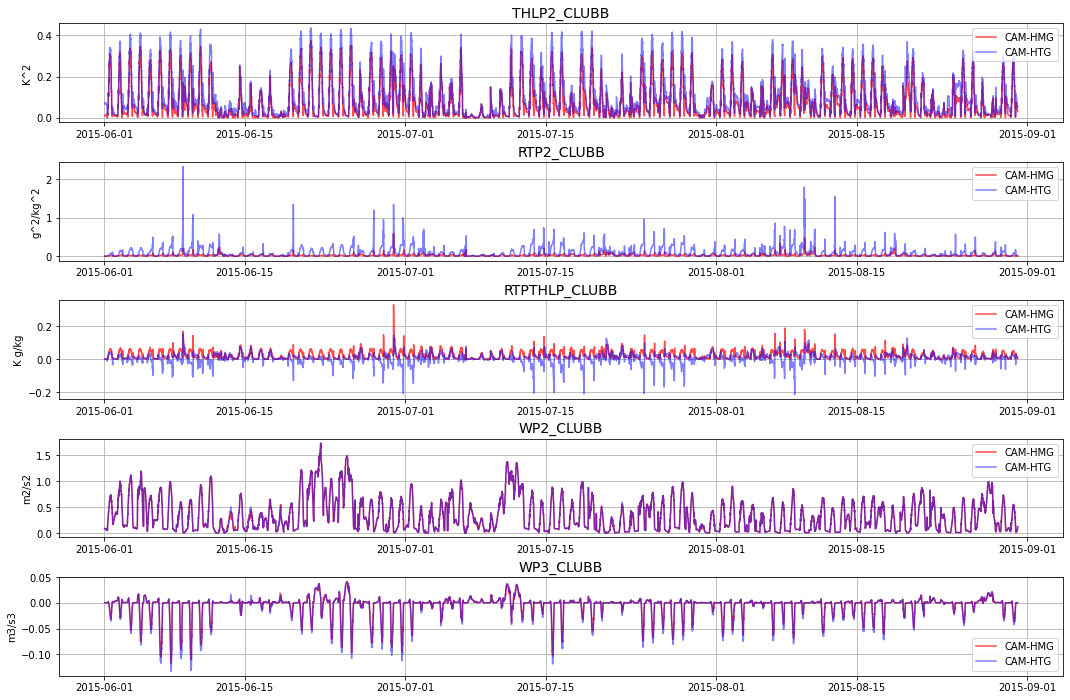

In [13]:
fig,axs = plt.subplots(5,1, figsize=(18,12))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB'])

for iVar in range(5):
    
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(hmgDS_origSfc_local['time'].values, np.squeeze(hmgDS_origSfc_local[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(htgDS_origSfc_local['time'].values, np.squeeze(htgDS_origSfc_local[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')   
        if plot_HTGmultiplied=='true':
            axs[iVar].plot(htgDS_x2_local['time'].values, np.squeeze(htgDS_x2_local[ATM_varNames[iVar]].values[:,-2,:,:]),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 
#             axs[iVar].plot(htgDS_x5_local['time'].values, np.squeeze(htgDS_x5_local[ATM_varNames[iVar]].values[:,-2,:,:]),
#                       '-',color='teal', alpha=0.7, label='CAM-HTG x5') 
        
    else:
        axs[iVar].plot(hmgDS_origSfc_local['time'].values, np.squeeze(hmgDS_origSfc_local[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(htgDS_origSfc_local['time'].values, np.squeeze(htgDS_origSfc_local[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')
        if plot_HTGmultiplied=='true':
            axs[iVar].plot(htgDS_x2_local['time'].values, np.squeeze(htgDS_x2_local[ATM_varNames[iVar]].values[:,-1,:,:]),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 
#             axs[iVar].plot(htgDS_x5_local['time'].values, np.squeeze(htgDS_x5_local[ATM_varNames[iVar]].values[:,-1,:,:]),
#                       '-',color='teal', alpha=0.7, label='CAM-HTG x5')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(hmgDS_origSfc[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])



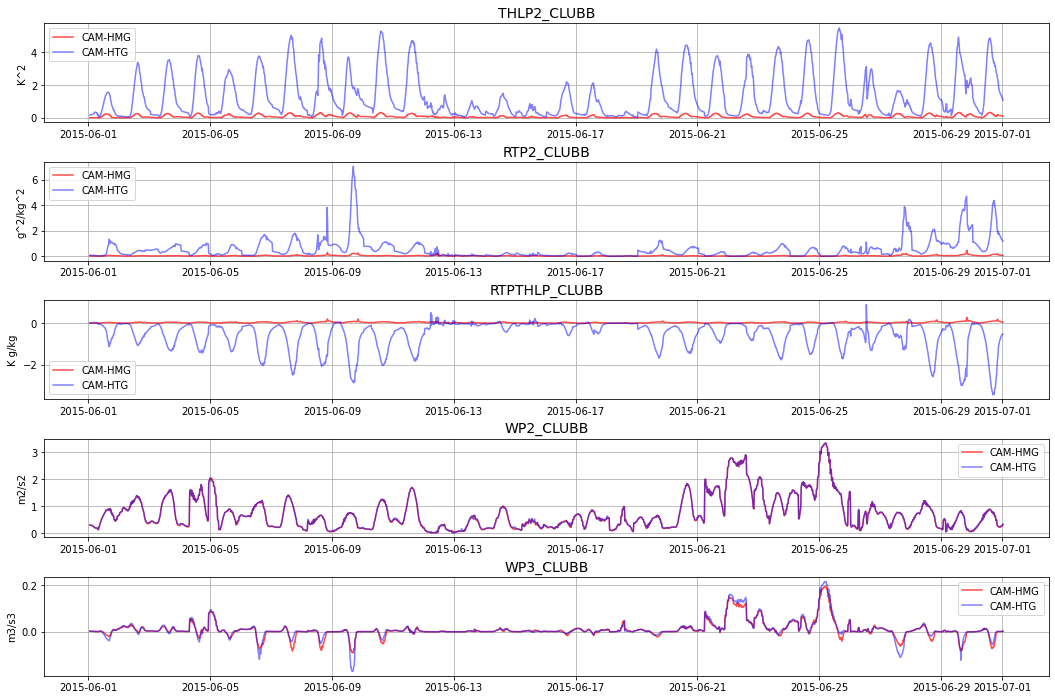

In [35]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(5,1, figsize=(18,12))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB'])

for iVar in range(5):
    
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(hmgDS_idlzSfc_local['time'].values, np.squeeze(hmgDS_idlzSfc_local[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(htgDS_idlzSfc_local['time'].values, np.squeeze(htgDS_idlzSfc_local[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')  
    else:
        axs[iVar].plot(hmgDS_idlzSfc_local['time'].values, np.squeeze(hmgDS_idlzSfc_local[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(htgDS_idlzSfc_local['time'].values, np.squeeze(htgDS_idlzSfc_local[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(hmgDS_idlzSfc[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])




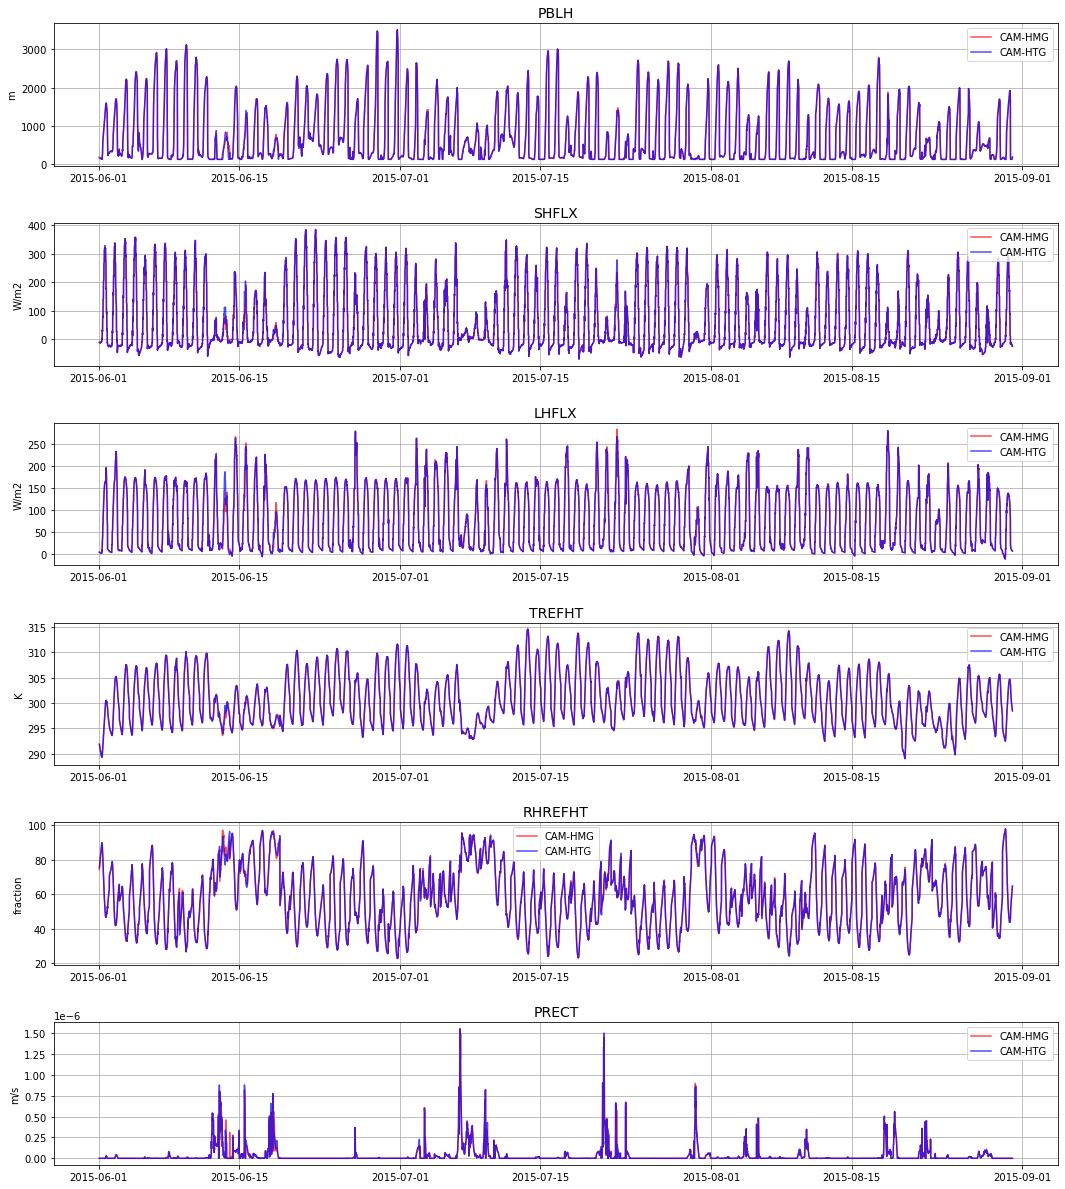

In [14]:
fig,axs = plt.subplots(6,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','PRECT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
        
    axs[iVar].plot(hmgDS_origSfc_local['time'].values, np.squeeze(hmgDS_origSfc_local[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(htgDS_origSfc_local['time'].values, np.squeeze(htgDS_origSfc_local[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')
    if plot_HTGmultiplied=='true':
            axs[iVar].plot(htgDS_x2_local['time'].values, np.squeeze(htgDS_x2_local[ATM_varNames[iVar]].values),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 
    
    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(hmgDS_origSfc[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
    


(16587.0, 16617.0)

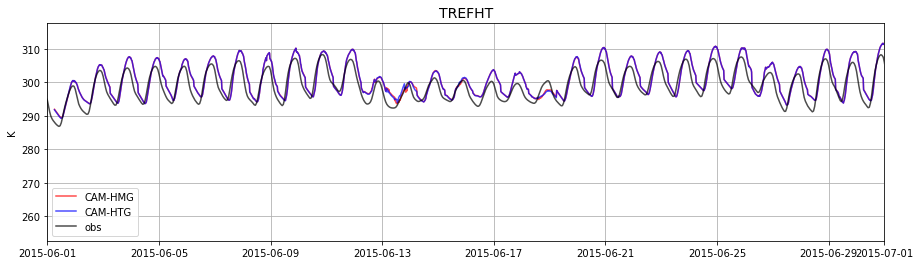

In [15]:
fig,ax1 = plt.subplots(1,1, figsize=(15,4))

ax1.plot(hmgDS_origSfc['time'].values, np.squeeze(hmgDS_origSfc['TREFHT'].values),
          'r-', alpha=0.7, label='CAM-HMG')
ax1.plot(htgDS_origSfc['time'].values, np.squeeze(htgDS_origSfc['TREFHT'].values),
          'b-', alpha=0.7, label='CAM-HTG')
ax1.plot(obsDS.time.values, obsT, 'k', alpha=0.7, label='obs')

ax1.set_title('TREFHT',fontsize=14)
ax1.set_ylabel(hmgDS_origSfc['TREFHT'].units)
ax1.legend()
ax1.grid()

ax1.set_xlim([datetime.date(2015,6,1), datetime.date(2015,7,1)])



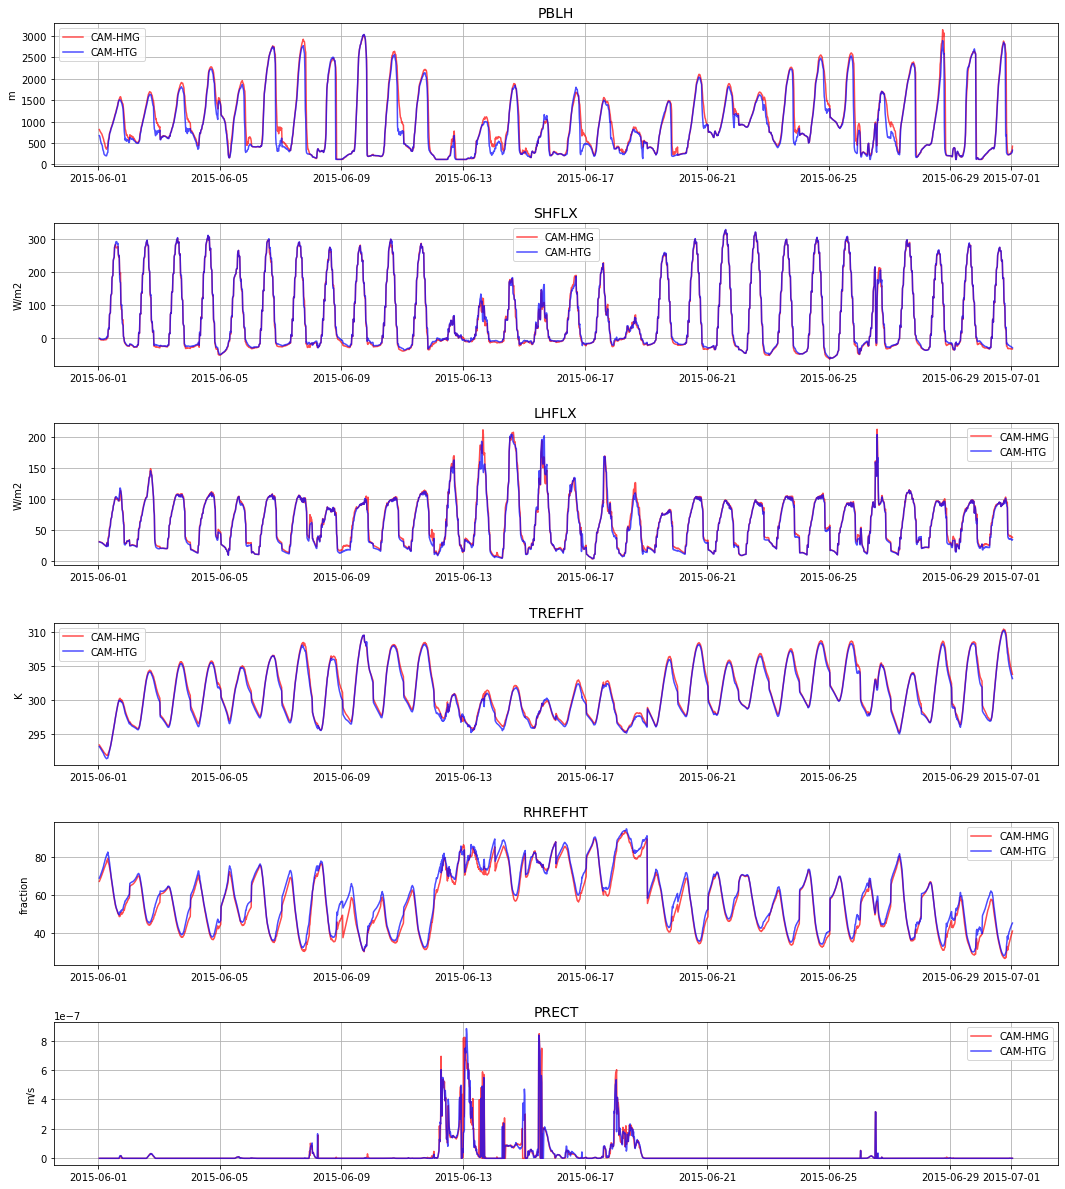

In [36]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(6,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','PRECT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
        
    axs[iVar].plot(hmgDS_idlzSfc_local['time'].values, np.squeeze(hmgDS_idlzSfc_local[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(htgDS_idlzSfc_local['time'].values, np.squeeze(htgDS_idlzSfc_local[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(hmgDS_idlzSfc[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()



Text(0.5, 1.0, 'CLDHGH')

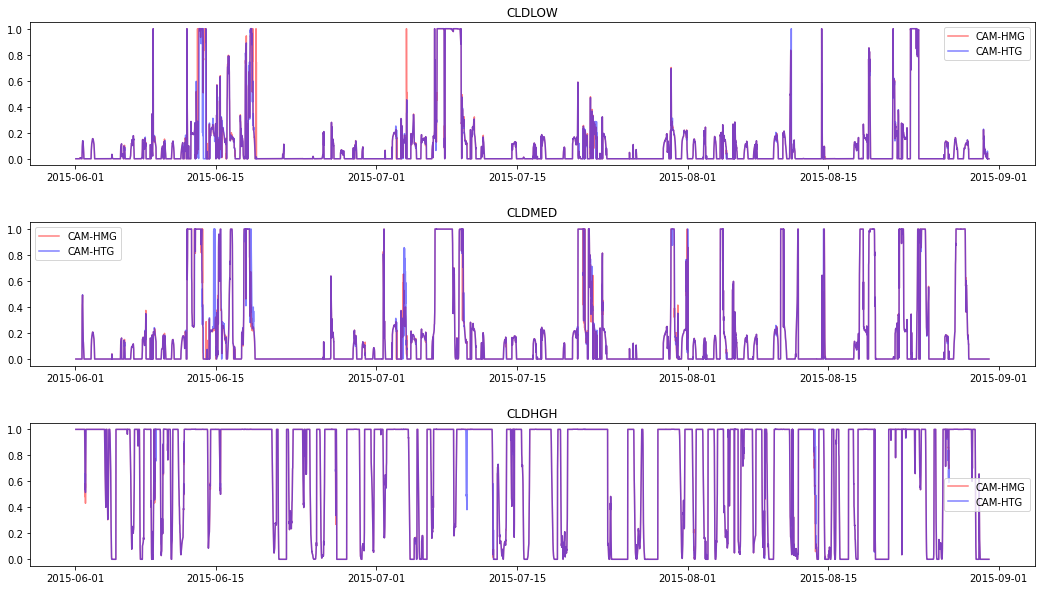

In [29]:
fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(hmgDS_origSfc_local['time'].values, np.squeeze(hmgDS_origSfc_local.CLDLOW.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[0].plot(htgDS_origSfc_local['time'].values, np.squeeze(htgDS_origSfc_local.CLDLOW.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[0].legend()
axs[0].set_title('CLDLOW')

axs[1].plot(hmgDS_origSfc_local['time'].values, np.squeeze(hmgDS_origSfc_local.CLDMED.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[1].plot(htgDS_origSfc_local['time'].values, np.squeeze(htgDS_origSfc_local.CLDMED.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[1].legend()
axs[1].set_title('CLDMED')

axs[2].plot(hmgDS_origSfc_local['time'].values, np.squeeze(hmgDS_origSfc_local.CLDHGH.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[2].plot(htgDS_origSfc_local['time'].values, np.squeeze(htgDS_origSfc_local.CLDHGH.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[2].legend()
axs[2].set_title('CLDHGH')



Text(0.5, 1.0, 'CLDHGH')

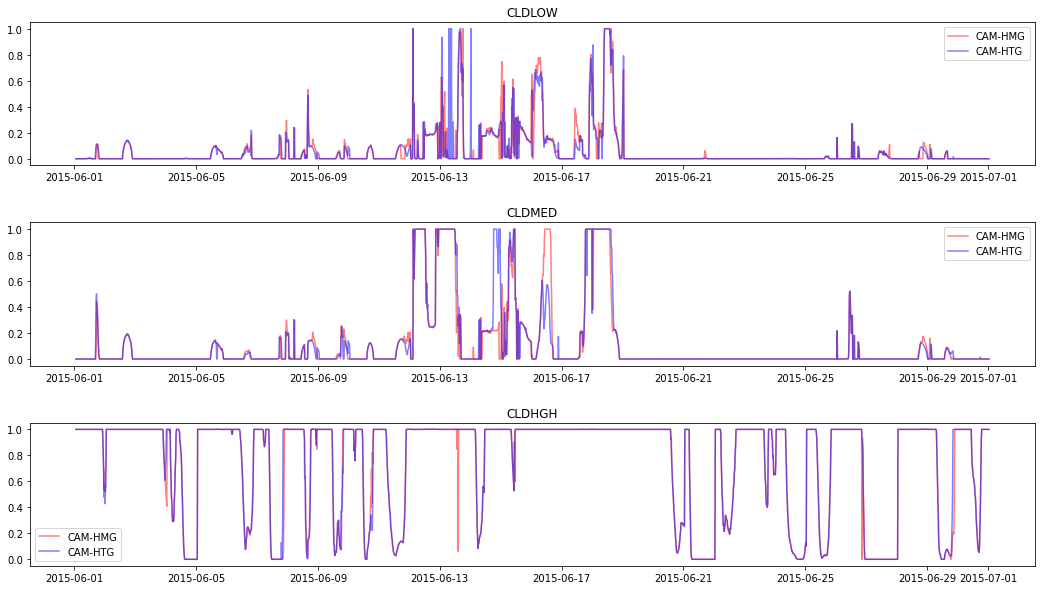

In [37]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(hmgDS_idlzSfc_local['time'].values, np.squeeze(hmgDS_idlzSfc_local.CLDLOW.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[0].plot(htgDS_idlzSfc_local['time'].values, np.squeeze(htgDS_idlzSfc_local.CLDLOW.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[0].legend()
axs[0].set_title('CLDLOW')

axs[1].plot(hmgDS_idlzSfc_local['time'].values, np.squeeze(hmgDS_idlzSfc_local.CLDMED.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[1].plot(htgDS_idlzSfc_local['time'].values, np.squeeze(htgDS_idlzSfc_local.CLDMED.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[1].legend()
axs[1].set_title('CLDMED')

axs[2].plot(hmgDS_idlzSfc_local['time'].values, np.squeeze(hmgDS_idlzSfc_local.CLDHGH.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[2].plot(htgDS_idlzSfc_local['time'].values, np.squeeze(htgDS_idlzSfc_local.CLDHGH.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[2].legend()
axs[2].set_title('CLDHGH')




Text(0.5, 1.0, 'U10')

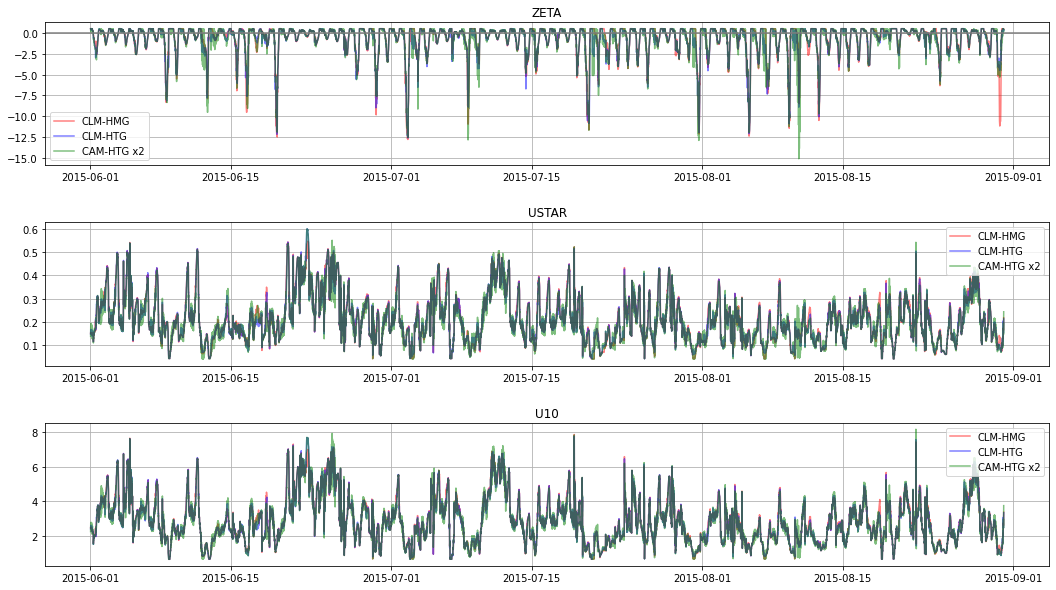

In [84]:
fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(hmgDSclm_origSfc_local['time'].values, np.squeeze(hmgDSclm_origSfc_local.ZETA.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[0].plot(htgDSclm_origSfc_local['time'].values, np.squeeze(htgDSclm_origSfc_local.ZETA.values), 'b-', alpha=0.5, label='CLM-HTG')
if plot_HTGmultiplied=='true':
    axs[0].plot(htgDS_x2_local['time'].values, np.squeeze(htgDSclm_x2_local.ZETA.values),
              '-',color='green', alpha=0.5, label='CAM-HTG x2') 
axs[0].legend()
axs[0].grid()
axs[0].axhline(0,color='grey')
axs[0].set_title('ZETA')
# axs[0].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[1].plot(hmgDSclm_origSfc_local['time'].values, np.squeeze(hmgDSclm_origSfc_local.USTAR.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[1].plot(htgDSclm_origSfc_local['time'].values, np.squeeze(htgDSclm_origSfc_local.USTAR.values), 'b-', alpha=0.5, label='CLM-HTG')
if plot_HTGmultiplied=='true':
    axs[1].plot(htgDS_x2_local['time'].values, np.squeeze(htgDSclm_x2_local.USTAR.values),
              '-',color='green', alpha=0.5, label='CAM-HTG x2') 
axs[1].legend()
axs[1].grid()
axs[1].set_title('USTAR')
# axs[1].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[2].plot(hmgDSclm_origSfc_local['time'].values, np.squeeze(hmgDSclm_origSfc_local.U10.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[2].plot(htgDSclm_origSfc_local['time'].values, np.squeeze(htgDSclm_origSfc_local.U10.values), 'b-', alpha=0.5, label='CLM-HTG')
if plot_HTGmultiplied=='true':
    axs[2].plot(htgDS_x2_local['time'].values, np.squeeze(htgDSclm_x2_local.U10.values),
              '-',color='green', alpha=0.5, label='CAM-HTG x2') 
axs[2].legend()
axs[2].grid()
axs[2].set_title('U10')
# axs[2].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])




Text(0.5, 1.0, 'U10')

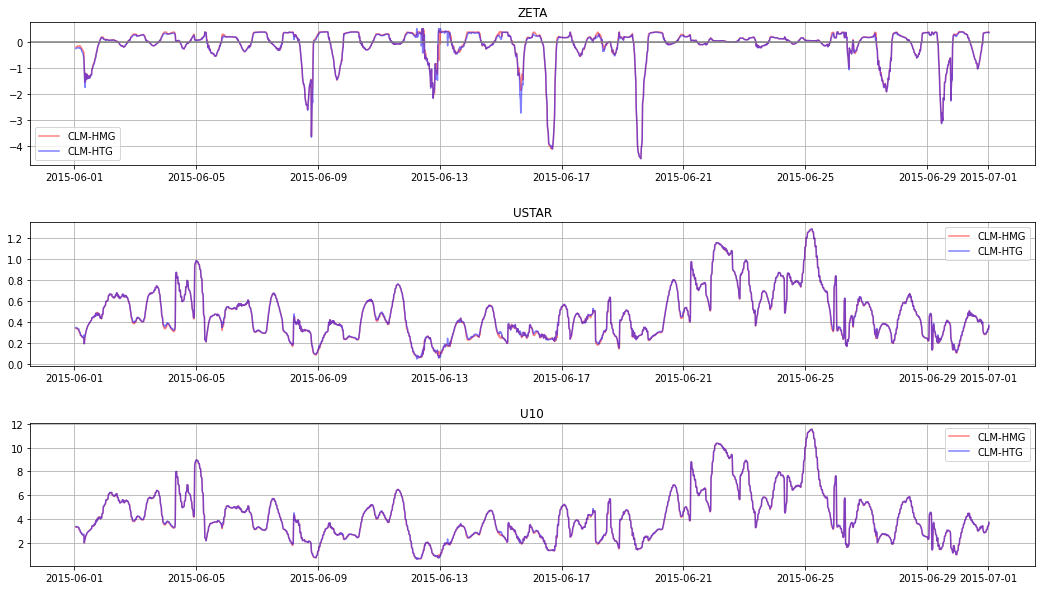

In [38]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(hmgDSclm_idlzSfc_local['time'].values, np.squeeze(hmgDSclm_idlzSfc_local.ZETA.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[0].plot(htgDSclm_idlzSfc_local['time'].values, np.squeeze(htgDSclm_idlzSfc_local.ZETA.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[0].legend()
axs[0].grid()
axs[0].axhline(0,color='grey')
axs[0].set_title('ZETA')
# axs[0].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[1].plot(hmgDSclm_idlzSfc_local['time'].values, np.squeeze(hmgDSclm_idlzSfc_local.USTAR.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[1].plot(htgDSclm_idlzSfc_local['time'].values, np.squeeze(htgDSclm_idlzSfc_local.USTAR.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[1].legend()
axs[1].grid()
axs[1].set_title('USTAR')
# axs[1].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[2].plot(hmgDSclm_idlzSfc_local['time'].values, np.squeeze(hmgDSclm_idlzSfc_local.U10.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[2].plot(htgDSclm_idlzSfc_local['time'].values, np.squeeze(htgDSclm_idlzSfc_local.U10.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[2].legend()
axs[2].grid()
axs[2].set_title('U10')
# axs[2].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])





## Diurnal cycle plots 

In [16]:
# Get means a function of hour of day
hourlyMean_HMG = hmgDS_origSfc_local.groupby("time.hour").mean()
hourlyMean_HTG = htgDS_origSfc_local.groupby("time.hour").mean()
hourlyMeanCLM_HMG = hmgDSclm_origSfc_local.groupby("time.hour").mean()
hourlyMeanCLM_HTG = htgDSclm_origSfc_local.groupby("time.hour").mean()


# hourlyMean_HTG_x2 = htgDS_x2_local.groupby("time.hour").mean()
# hourlyMeanCLM_HTG_x2 = htgDSclm_x2_local.groupby("time.hour").mean()


In [39]:
# Get means a function of hour of day
hourlyMeanIdlz_HMG = hmgDS_idlzSfc_local.groupby("time.hour").mean()
hourlyMeanIdlz_HTG = htgDS_idlzSfc_local.groupby("time.hour").mean()

hourlyMeanIdlzCLM_HMG = hmgDSclm_idlzSfc_local.groupby("time.hour").mean()
hourlyMeanIdlzCLM_HTG = htgDSclm_idlzSfc_local.groupby("time.hour").mean()

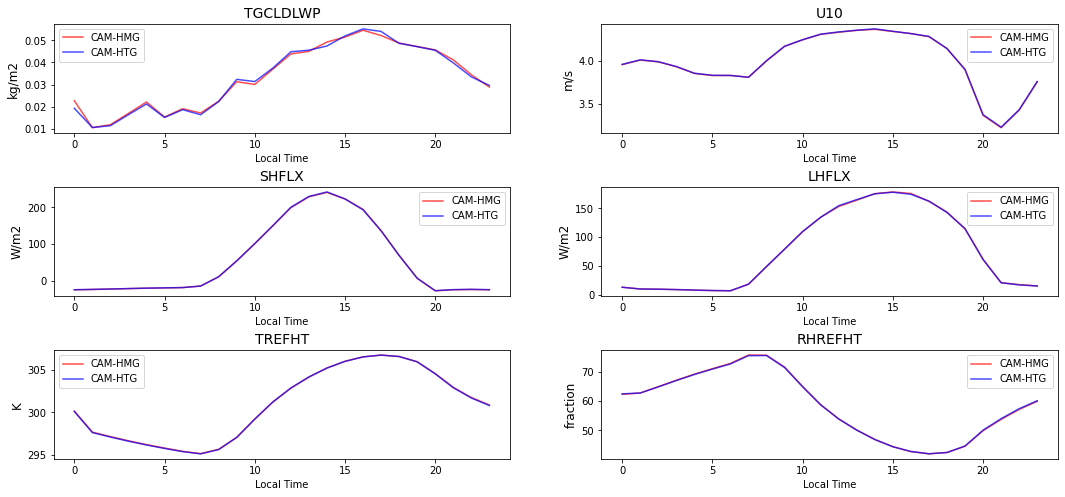

In [19]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','U10'])
ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):       
    axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')
    if plot_HTGmultiplied=='true':
            axs[iVar].plot(hourlyMean_HTG_x2.hour.values, np.squeeze(hourlyMean_HTG_x2[ATM_varNames[iVar]].values),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 
    

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(hmgDS_origSfc[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(hmgDS_origSfc['T'].units, fontsize=12)
        

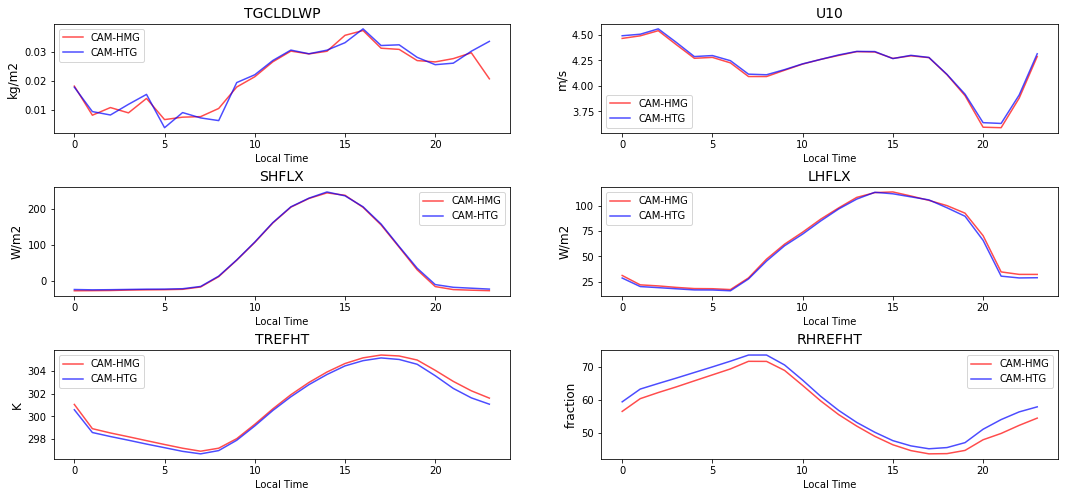

In [40]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(3,2, figsize=(18,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

#ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','U10'])
ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):       
    axs[iVar].plot(hourlyMeanIdlz_HMG.hour.values, np.squeeze(hourlyMeanIdlz_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(hourlyMeanIdlz_HTG.hour.values, np.squeeze(hourlyMeanIdlz_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(hmgDS_idlzSfc[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(hmgDS_idlzSfc['T'].units, fontsize=12)
        

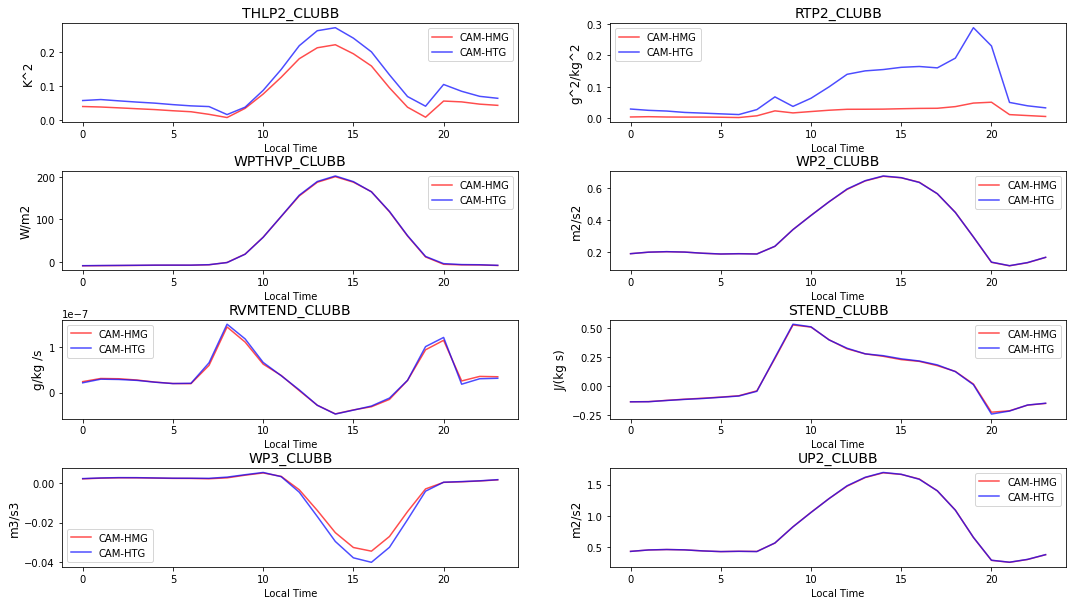

In [20]:
fig,axs = plt.subplots(4,2, figsize=(18,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])

for iVar in range(8):       
    if ATM_varNames[iVar]!='WP3_CLUBB':
        axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1]),
                      'b-', alpha=0.7, label='CAM-HTG')
        if plot_HTGmultiplied=='true':
            axs[iVar].plot(hourlyMean_HTG_x2.hour.values, np.squeeze(hourlyMean_HTG_x2[ATM_varNames[iVar]].values[:,-1]),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 


    else:
        axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2]),
                      'b-', alpha=0.7, label='CAM-HTG')
        if plot_HTGmultiplied=='true':
            axs[iVar].plot(hourlyMean_HTG_x2.hour.values, np.squeeze(hourlyMean_HTG_x2[ATM_varNames[iVar]].values[:,-2]),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 


        
    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(hmgDS_origSfc[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(hmgDS_origSfc['T'].units, fontsize=12)
        

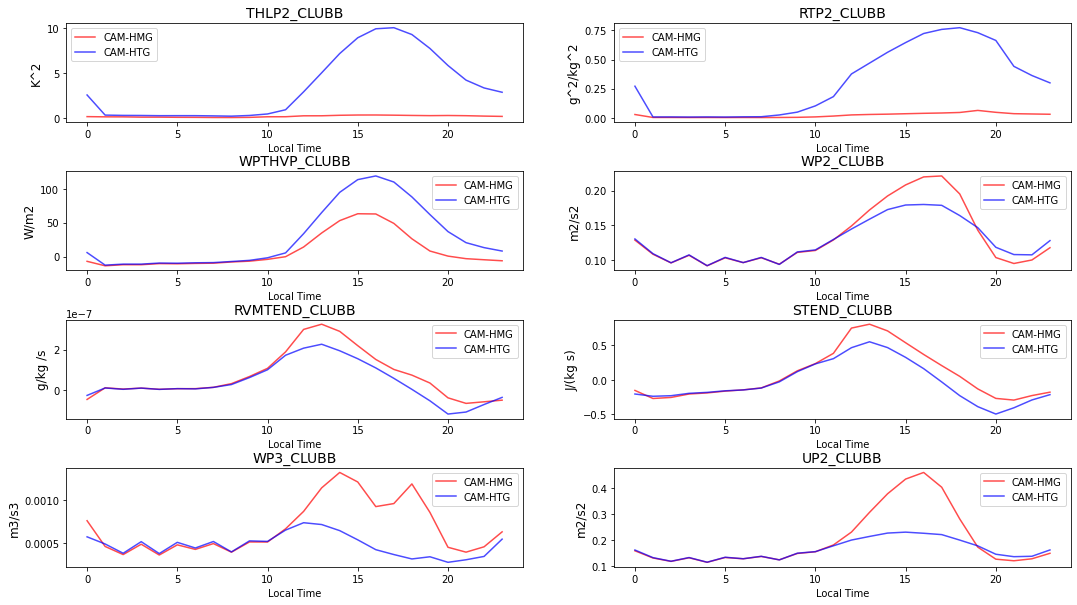

In [67]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(4,2, figsize=(18,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])

for iVar in range(8):       
    if ATM_varNames[iVar]!='WP3_CLUBB':
        axs[iVar].plot(hourlyMeanIdlz_HMG.hour.values, np.squeeze(hourlyMeanIdlz_HMG[ATM_varNames[iVar]].values[:,-1]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMeanIdlz_HTG.hour.values, np.squeeze(hourlyMeanIdlz_HTG[ATM_varNames[iVar]].values[:,-1]),
                      'b-', alpha=0.7, label='CAM-HTG')
    else:
        axs[iVar].plot(hourlyMeanIdlz_HMG.hour.values, np.squeeze(hourlyMeanIdlz_HMG[ATM_varNames[iVar]].values[:,-2]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMeanIdlz_HTG.hour.values, np.squeeze(hourlyMeanIdlz_HTG[ATM_varNames[iVar]].values[:,-2]),
                      'b-', alpha=0.7, label='CAM-HTG')
        
    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(hmgDS_idlzSfc[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(hmgDS_idlzSfc['T'].units, fontsize=12)
        

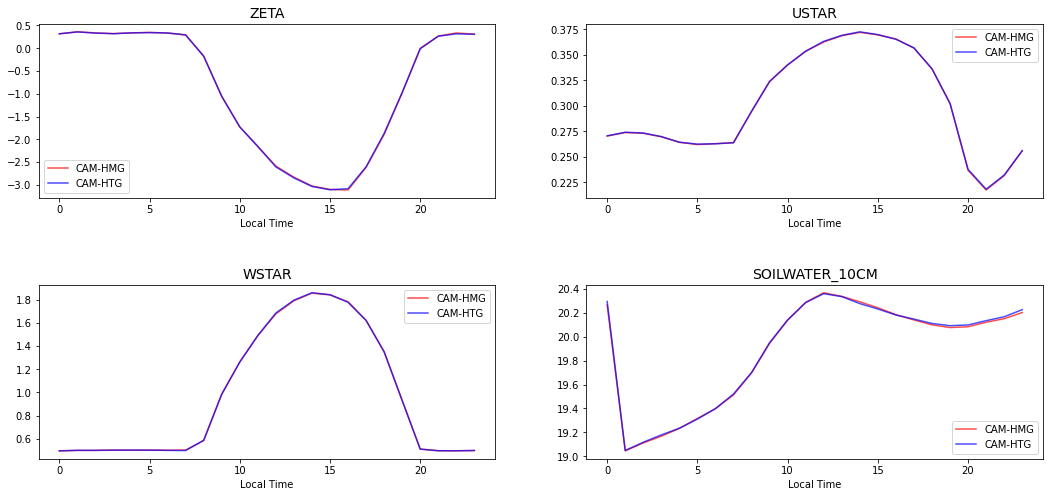

In [21]:
fig,axs = plt.subplots(2,2, figsize=(18,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['ZETA','USTAR','WSTAR','SOILWATER_10CM'])
#ATM_varNames = np.asarray(['TGCLDLWP','SHFLX','LHFLX','TREFHT','RHREFHT','U10'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(4):       
    axs[iVar].plot(hourlyMeanCLM_HMG.hour.values, np.squeeze(hourlyMeanCLM_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(hourlyMeanCLM_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')
    if plot_HTGmultiplied=='true':
            axs[iVar].plot(hourlyMeanCLM_HTG_x2.hour.values, np.squeeze(hourlyMeanCLM_HTG_x2[ATM_varNames[iVar]].values),
                      '-',color='green', alpha=0.5, label='CAM-HTG x2') 
    

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
 

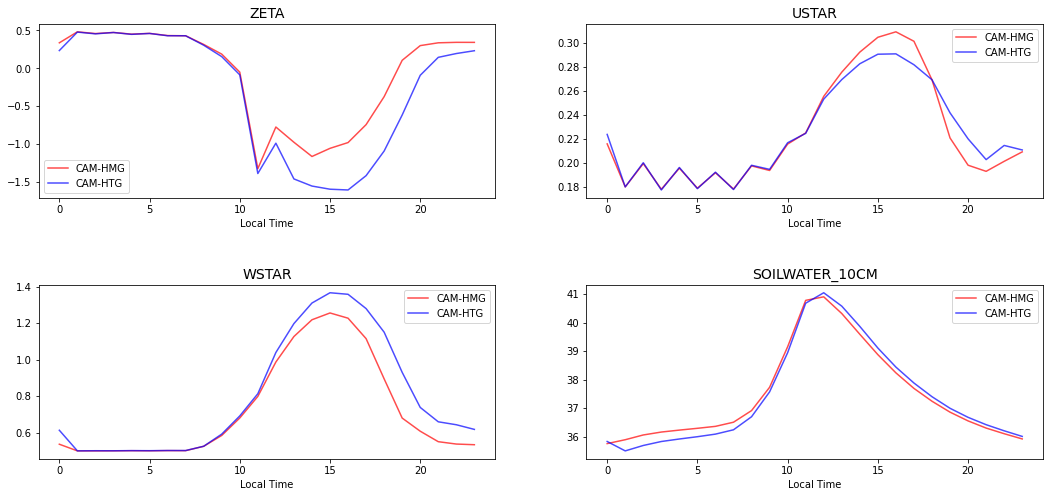

In [68]:
# - - - - - - - - - - - - - - - - - - - 
### Plot idealized surface runs 
# - - - - - - - - - - - - - - - - - - - 

fig,axs = plt.subplots(2,2, figsize=(18,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['ZETA','USTAR','WSTAR','SOILWATER_10CM'])
#ATM_varNames = np.asarray(['TGCLDLWP','SHFLX','LHFLX','TREFHT','RHREFHT','U10'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(4):       
    axs[iVar].plot(hourlyMeanIdlzCLM_HMG.hour.values, np.squeeze(hourlyMeanIdlzCLM_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(hourlyMeanIdlzCLM_HTG.hour.values, np.squeeze(hourlyMeanIdlzCLM_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
 

## Vertical info plots

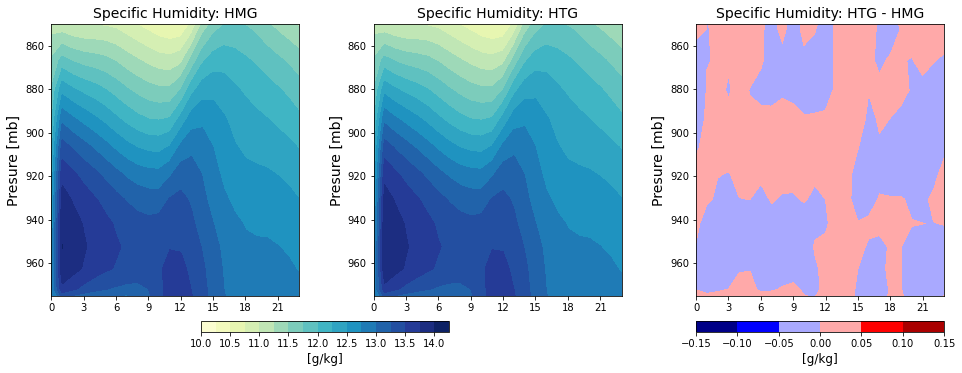

In [24]:
fig, axs_all = plt.subplots(1,3, figsize=(16, 5),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.6,wspace=0.3)

Qlevs = np.arange(10.0,14.5,0.25)
Qdiff_levs = np.arange(-0.15,0.2,0.05)


contour_plot = axs[0].contourf(hourlyMean_HMG.hour.values,hourlyMean_HMG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HMG.Q.values)*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[0].set_ylim([850,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Specific Humidity: HMG', fontsize=14)
axs[0].invert_yaxis()

contour_plot = axs[1].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.Q.values)*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[1].set_ylim([850,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_ylabel('Presure [mb]',fontsize=14)
axs[1].set_title('Specific Humidity: HTG', fontsize=14)
axs[1].invert_yaxis()

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


# Plot difference 
contour_plot = axs[2].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.Q.values)*1000.0 - np.squeeze(hourlyMean_HMG.Q.values)*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[2].set_ylim([850,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_ylabel('Presure [mb]',fontsize=14)
axs[2].set_title('Specific Humidity: HTG - HMG', fontsize=14)
axs[2].invert_yaxis()

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[g/kg]',fontsize=12)


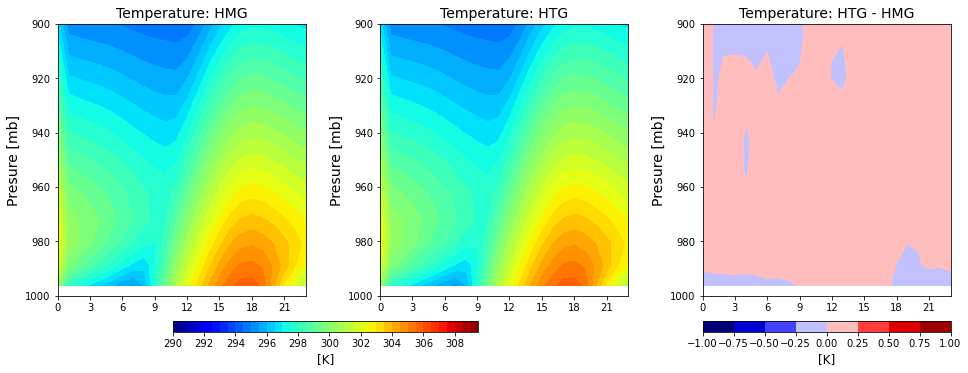

In [28]:
fig, axs_all = plt.subplots(1,3, figsize=(16, 5),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.6, wspace=0.3)

Tlevs = np.arange(290,310,0.5)
Tdiff_levs = np.arange(-1.0,1.25,0.25)


contour_plot = axs[0].contourf(hourlyMean_HMG.hour.values,hourlyMean_HMG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HMG.T.values)), Tlevs,
                      cmap='jet')
axs[0].set_ylim([900,1000])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Temperature: HMG', fontsize=14)
axs[0].invert_yaxis()
# ax01 = axs[0].twinx()
# ax01.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG.TREFHT.values),'o-', 
#            color = 'white')
# ax01.set_ylim([275,310])
# ax01.set_ylabel('TREFHT [K]')

contour_plot = axs[1].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.T.values)), Tlevs,
                      cmap='jet')
axs[1].set_ylim([900,1000])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_ylabel('Presure [mb]',fontsize=14)
axs[1].set_title('Temperature: HTG', fontsize=14)
axs[1].invert_yaxis()

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.18, ax_position.y0-0.1, ax_position.width+0.05, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)
# ax01 = axs[1].twinx()
# ax01.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HTG.TREFHT.values),'o-', 
#            color = 'white')
# ax01.set_ylim([275,310])
# ax01.set_ylabel('TREFHT [K]')


# Plot difference 
contour_plot = axs[2].contourf(hourlyMean_HTG.hour.values,hourlyMean_HTG.lev.values, 
                       np.transpose(np.squeeze(hourlyMean_HTG.T.values) - np.squeeze(hourlyMean_HMG.T.values)), 
                       Tdiff_levs,
                       cmap='seismic')
axs[2].set_ylim([900,1000])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_ylabel('Presure [mb]',fontsize=14)
axs[2].set_title('Temperature: HTG - HMG', fontsize=14)
axs[2].invert_yaxis()

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('[K]',fontsize=12)

